# Twitter Sentiment Analysis

### About Data

## Collecting/Getting Data

#### Dependencies

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords 
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier




plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Read Data from csv file
tweets_data = pd.read_csv("train.csv",encoding='ISO-8859-1')

## Explore and Clean Data

### 1 Explore and understand data 

In [3]:
tweets_data

,ItemID,sentiment,text
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,Omgaga. Im sooo im gunna CRy. I've been at th...
4,5,0,i think mi bf is cheating on me!!! T_T
...,...,...,...
99983,99996,0,@Cupcake seems like a repeating problem hop...
99984,99997,1,@cupcake__ arrrr we both replied to each other...
99985,99998,0,@CuPcAkE_2120 ya i thought so
99986,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [4]:
tweets_data.columns

Index(['ItemID', 'sentiment', 'text'], dtype='object')

We don't need 'ItemID' column

In [5]:
tweets_data =tweets_data.drop(['ItemID'], axis=1)
tweets_data

,sentiment,text
0,0,is so sad for my APL friend.............
1,0,I missed the New Moon trailer...
2,1,omg its already 7:30 :O
3,0,Omgaga. Im sooo im gunna CRy. I've been at th...
4,0,i think mi bf is cheating on me!!! T_T
...,...,...
99983,0,@Cupcake seems like a repeating problem hop...
99984,1,@cupcake__ arrrr we both replied to each other...
99985,0,@CuPcAkE_2120 ya i thought so
99986,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [6]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99988 entries, 0 to 99987
Data columns (total 2 columns):
sentiment    99988 non-null int64
text         99988 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
#for counting ham and spam

tweets_data.sentiment.value_counts()

1    56456
0    43532
Name: sentiment, dtype: int64

In [8]:
tweets_data.groupby('sentiment').describe()

text                                                            \
           count unique                                                top   
sentiment                                                                    
0          43532  43532           @Alex_Lately I wish there was food here!   
1          56456  56456  @ClipperPrincess I've been biking after watchi...   

                
          freq  
sentiment       
0            1  
1            1

### 2 Clean Data

In [9]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [11]:
lenn = len(tweets_data)
lenn
tweets_data.text

0                 is so sad for my APL friend.............
1                         I missed the New Moon trailer...
2                                  omg its already 7:30 :O
3        Omgaga. Im sooo  im gunna CRy. I've been at th...
4             i think mi bf is cheating on me!!!       T_T
                               ...                        
99983    @Cupcake  seems like a repeating problem   hop...
99984    @cupcake__ arrrr we both replied to each other...
99985                        @CuPcAkE_2120 ya i thought so
99986    @Cupcake_Dollie Yes. Yes. I'm glad you had mor...
99987                       @cupcake_kayla haha yes you do
Name: text, Length: 99988, dtype: object

In [12]:
tweets_data[tweets_data.isnull().any(axis=1)].head()

,sentiment,text


We don't have NaN data for now

In [14]:
%%time
print ("Cleaning the tweets...\n")
clean_tweet_texts = []
for row in tweets_data.text:
    clean_tweet_texts.append(tweet_cleaner_updated(row))

Cleaning the tweets...

CPU times: user 26 s, sys: 1.49 s, total: 27.5 s
Wall time: 27.8 s


In [15]:
clean_tweet_texts

['is so sad for my apl friend',
 'missed the new moon trailer',
 'omg its already',
 'omgaga im sooo im gunna cry ve been at this dentist since was suposed just get crown put on mins',
 'think mi bf is cheating on me',
 'or just worry too much',
 'sunny again work tomorrow tv tonight',
 'handed in my uniform today miss you already',
 'hmmmm wonder how she my number',
 'must think about positive',
 'thanks to all the haters up in my face all day',
 'this weekend has sucked so far',
 'jb isnt showing in australia any more',
 'ok thats it you win',
 'this is the way feel right now',
 'awhhe man completely useless rt now funny all can do is twitter',
 'feeling strangely fine now gonna go listen to some semisonic to celebrate',
 'huge roll of thunder just now so scary',
 'just cut my beard off it only been growing for well over year gonna start it over is happy in the meantime',
 'very sad about iran',
 'wompppp wompp',
 'you re the only one who can see this cause no one else is following m

In [16]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['sentiment'] = tweets_data.sentiment
clean_df.to_csv('clean_imdb.csv',encoding='utf-8')

In [17]:
csv = 'clean_imdb.csv'
clean_tweets_data = pd.read_csv(csv,index_col=0)
clean_tweets_data

,text,sentiment
0,is so sad for my apl friend,0
1,missed the new moon trailer,0
2,omg its already,1
3,omgaga im sooo im gunna cry ve been at this de...,0
4,think mi bf is cheating on me,0
...,...,...
99983,seems like repeating problem hope you re able ...,0
99984,arrrr we both replied to each other over diffe...,1
99985,ya thought so,0
99986,yes yes glad you had more fun with me,1


In [18]:
clean_tweets_data[clean_tweets_data.isnull().any(axis=1)]

,text,sentiment
225,NaN,1
228,NaN,1
233,NaN,0
252,NaN,0
694,NaN,1
...,...,...
99361,NaN,0
99441,NaN,1
99583,NaN,0
99651,NaN,1


We have NaN data, we have to clean our data

In [19]:
np.sum(clean_tweets_data.isnull().any(axis=1))

465

In [20]:
clean_tweets_data.isnull().any(axis=0)

text          True
sentiment    False
dtype: bool

In [21]:
clean_tweets_data.dropna(inplace=True)
clean_tweets_data.reset_index(drop=True,inplace=True)
clean_tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99523 entries, 0 to 99522
Data columns (total 2 columns):
text         99523 non-null object
sentiment    99523 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


## Data Visualition

Text(0.5,1,'Distribution of Positive and Negative')

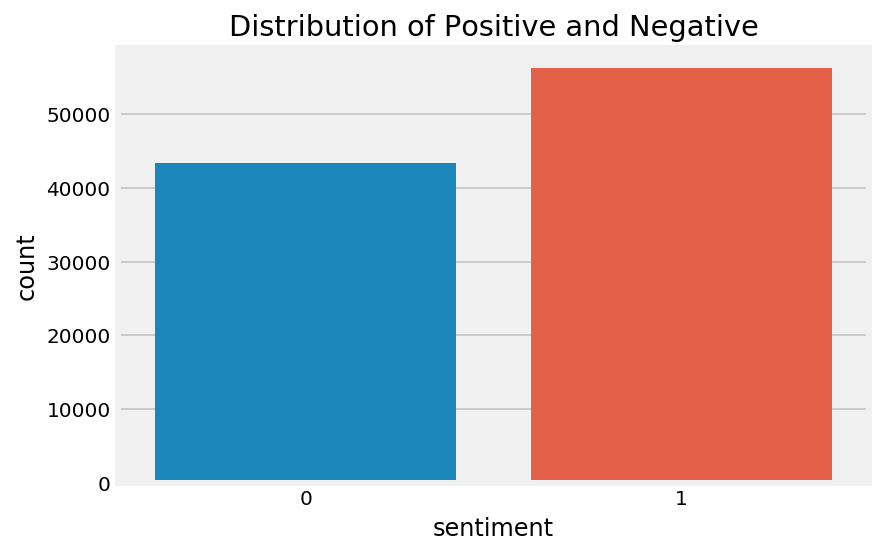

In [22]:
#plotting graph for distribution

sns.countplot(x = "sentiment", data = clean_tweets_data)
clean_tweets_data.loc[:,'sentiment'].value_counts()
plt.title('Distribution of Positive and Negative')

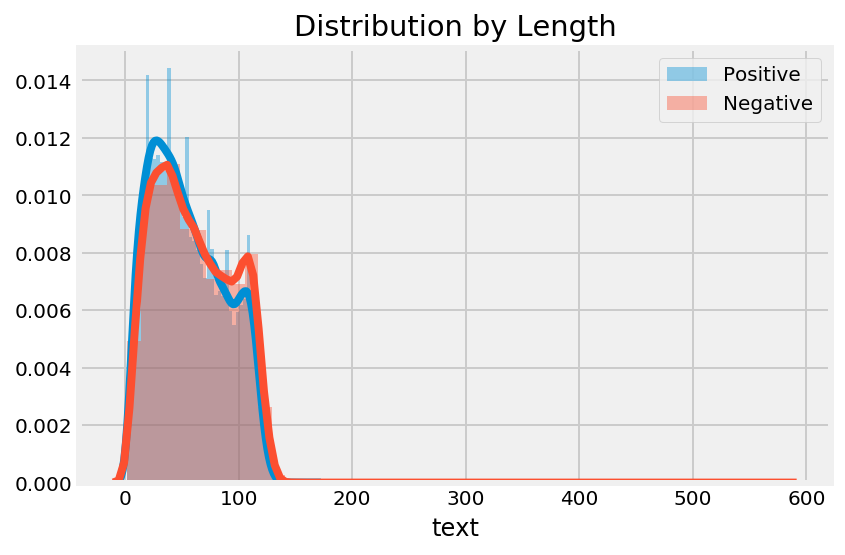

In [23]:
# plotting graph by length.

pos =clean_tweets_data[clean_tweets_data['sentiment'] == 1]['text'].str.len()
sns.distplot(pos, label='Positive')
neg = clean_tweets_data[clean_tweets_data['sentiment'] == 0]['text'].str.len()
sns.distplot(neg, label='Negative')
plt.title('Distribution by Length')
plt.legend()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


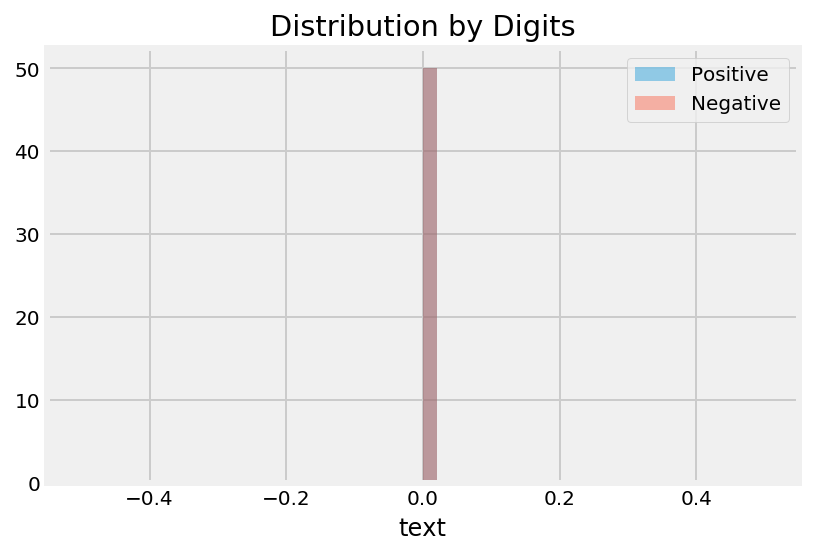

In [24]:
#plotting graph by digits.

pos1 = clean_tweets_data[clean_tweets_data['sentiment'] == 1 ]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(pos1, label='Positive')
neg1 = clean_tweets_data[clean_tweets_data['sentiment'] == 0 ]['text'].str.replace(r'\D+', '').str.len()
sns.distplot(neg1, label='Negative')
plt.title('Distribution by Digits')
plt.legend()

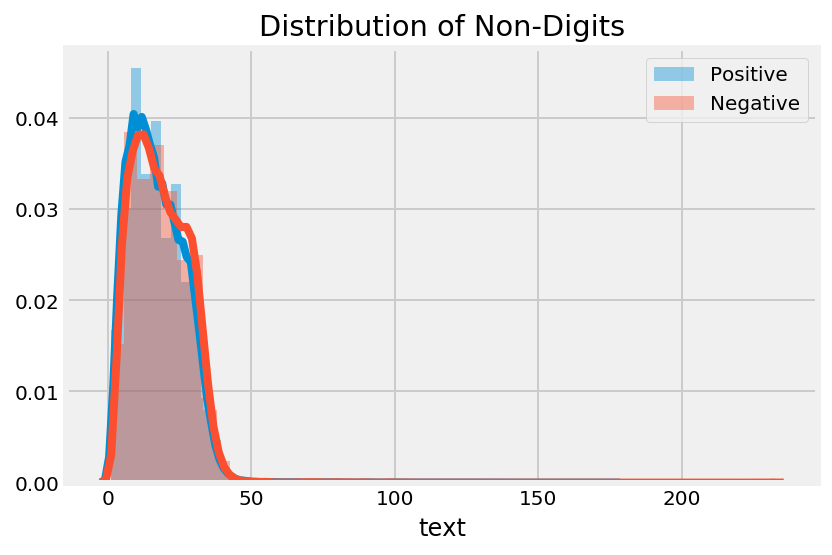

In [25]:
#plotting graph for non-digits.

pos2 = tweets_data[tweets_data['sentiment'] == 1]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(pos2, label='Positive')
neg2 = tweets_data[tweets_data['sentiment'] == 0]['text'].str.replace(r'\w+', '').str.len()
sns.distplot(neg2, label='Negative')
plt.title('Distribution of Non-Digits')
plt.legend()

In [26]:
from collections import Counter
#for counting frequently occurence of pos and neg.

count1 = Counter(" ".join(clean_tweets_data[clean_tweets_data['sentiment']== 1]["text"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of pos", 1 : "count"})
count2 = Counter(" ".join(clean_tweets_data[clean_tweets_data['sentiment']== 0]["text"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of neg", 1 : "count_"})

#### Graph for top 30 words of positive

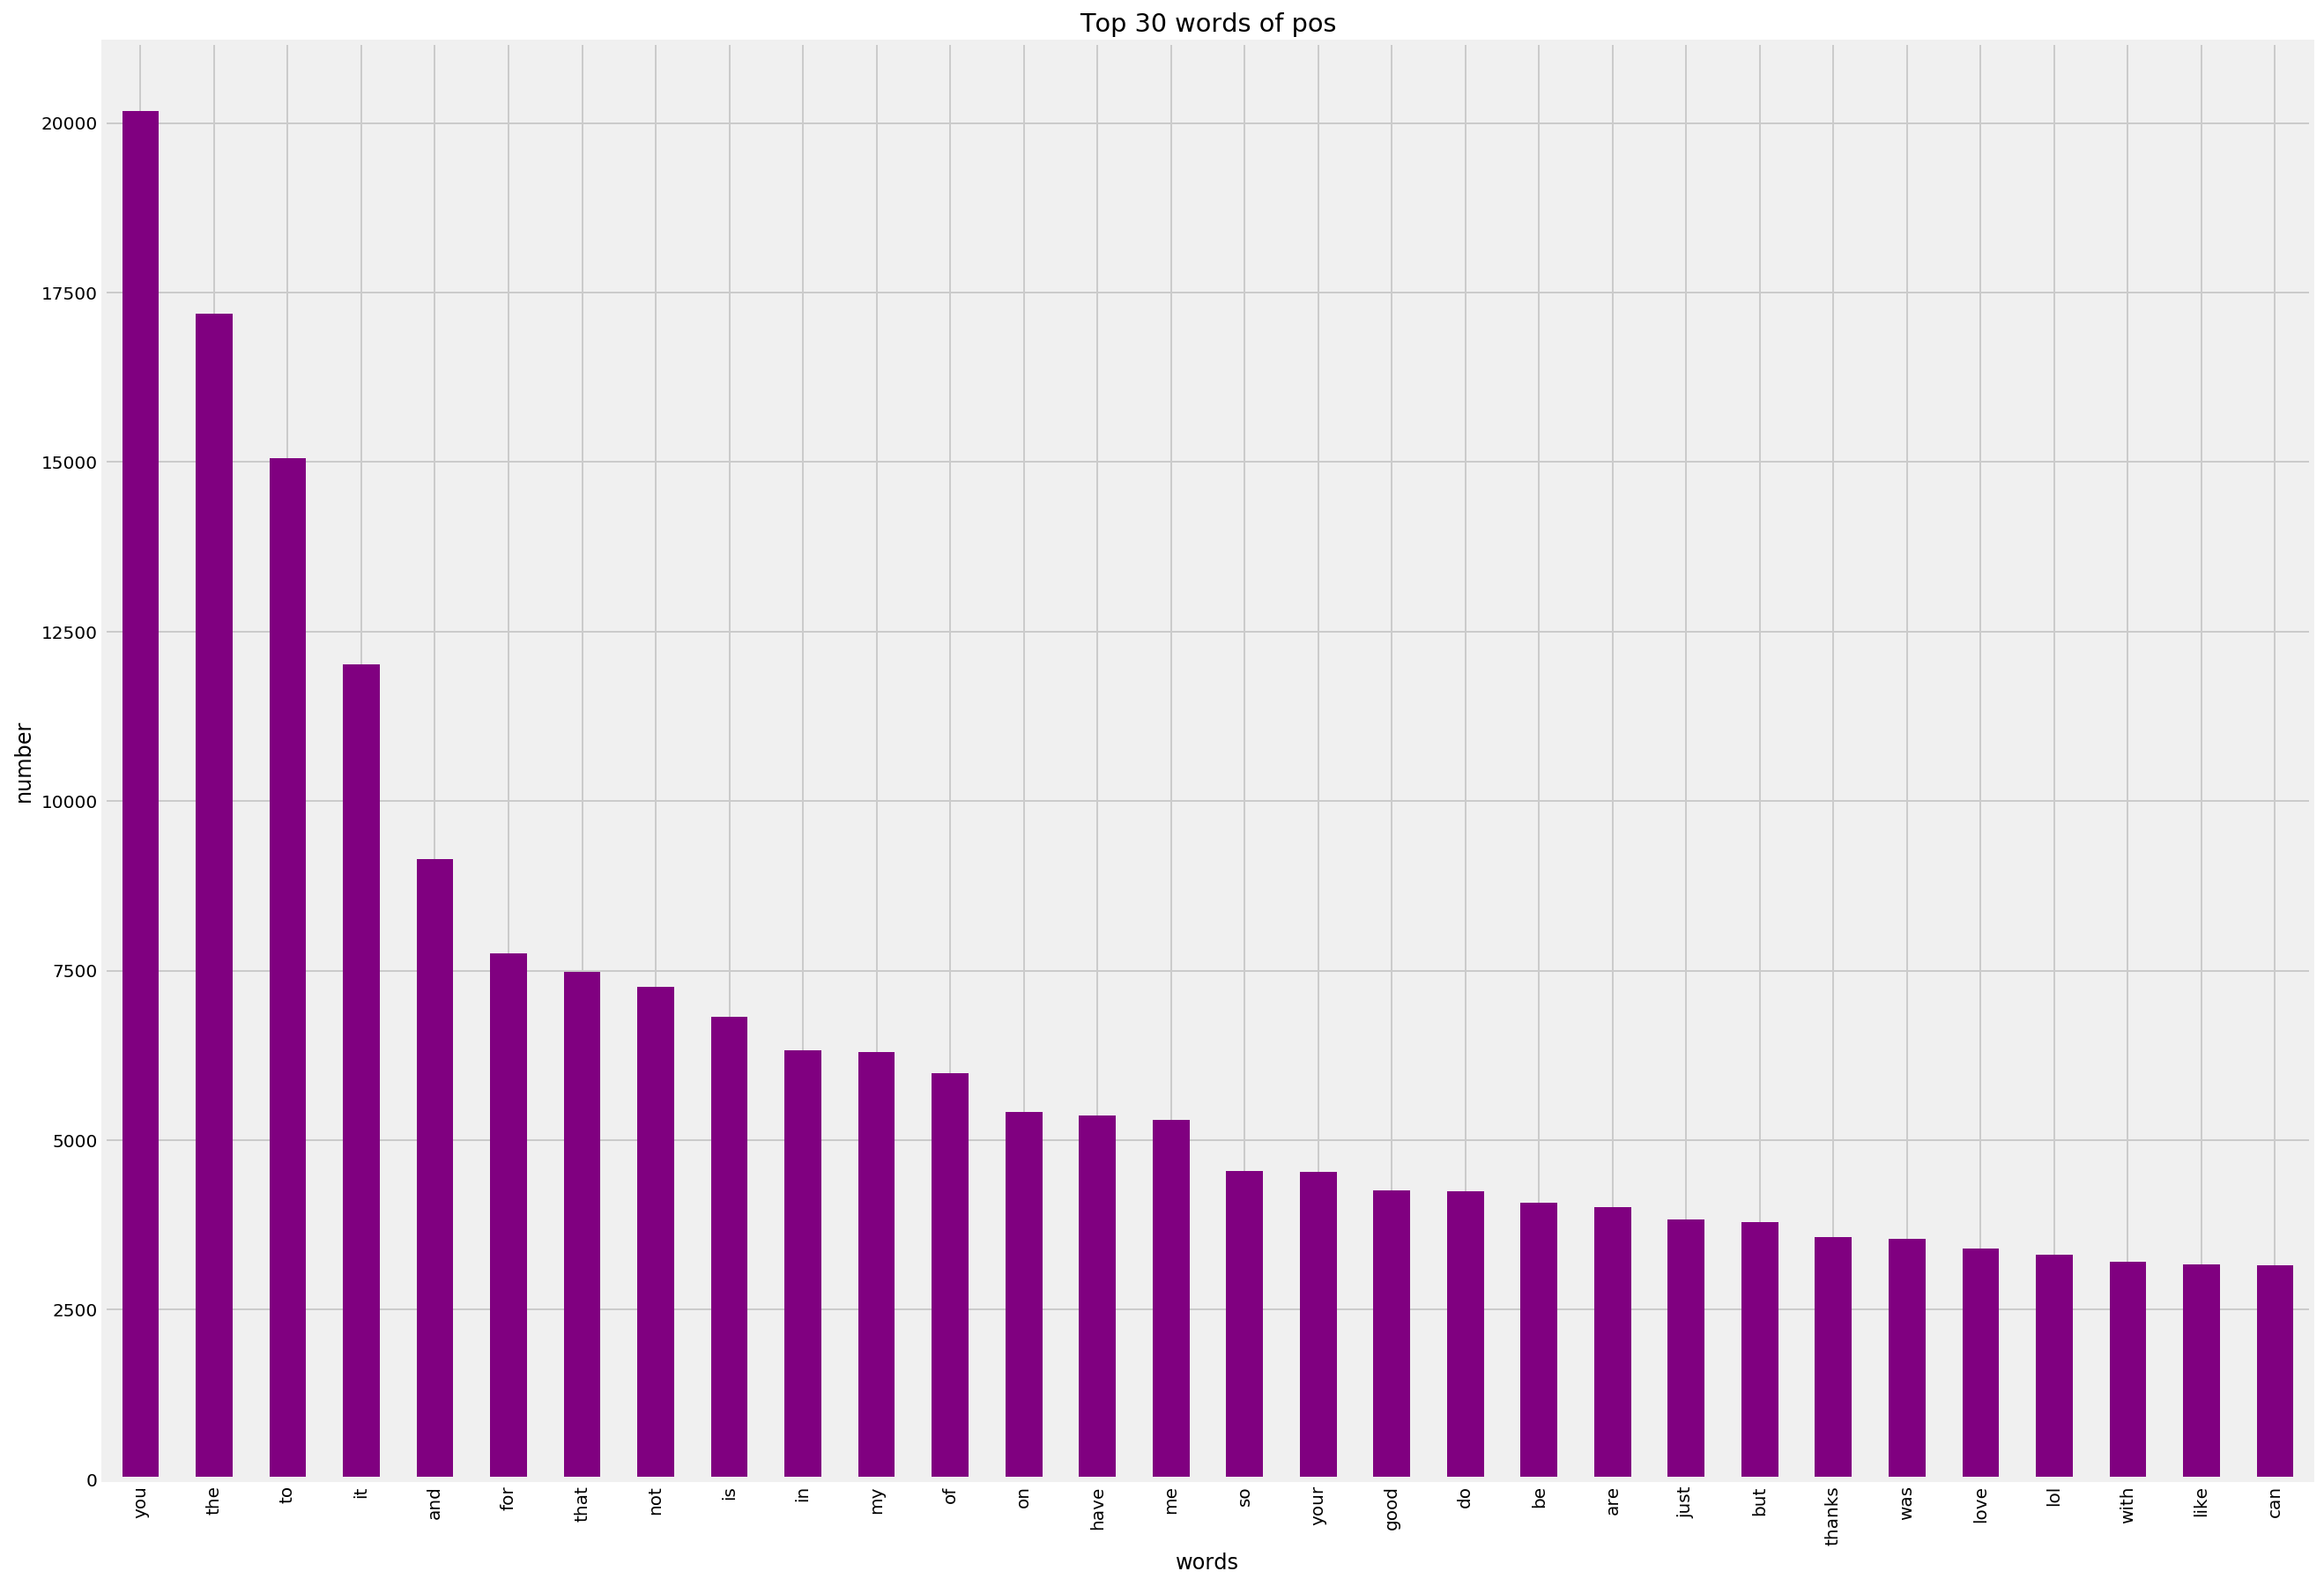

In [27]:
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data1["words of pos"]))
plt.xticks(y_pos, data1["words of pos"])
plt.title('Top 30 words of pos')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

#### Graph for top 30 words of negative

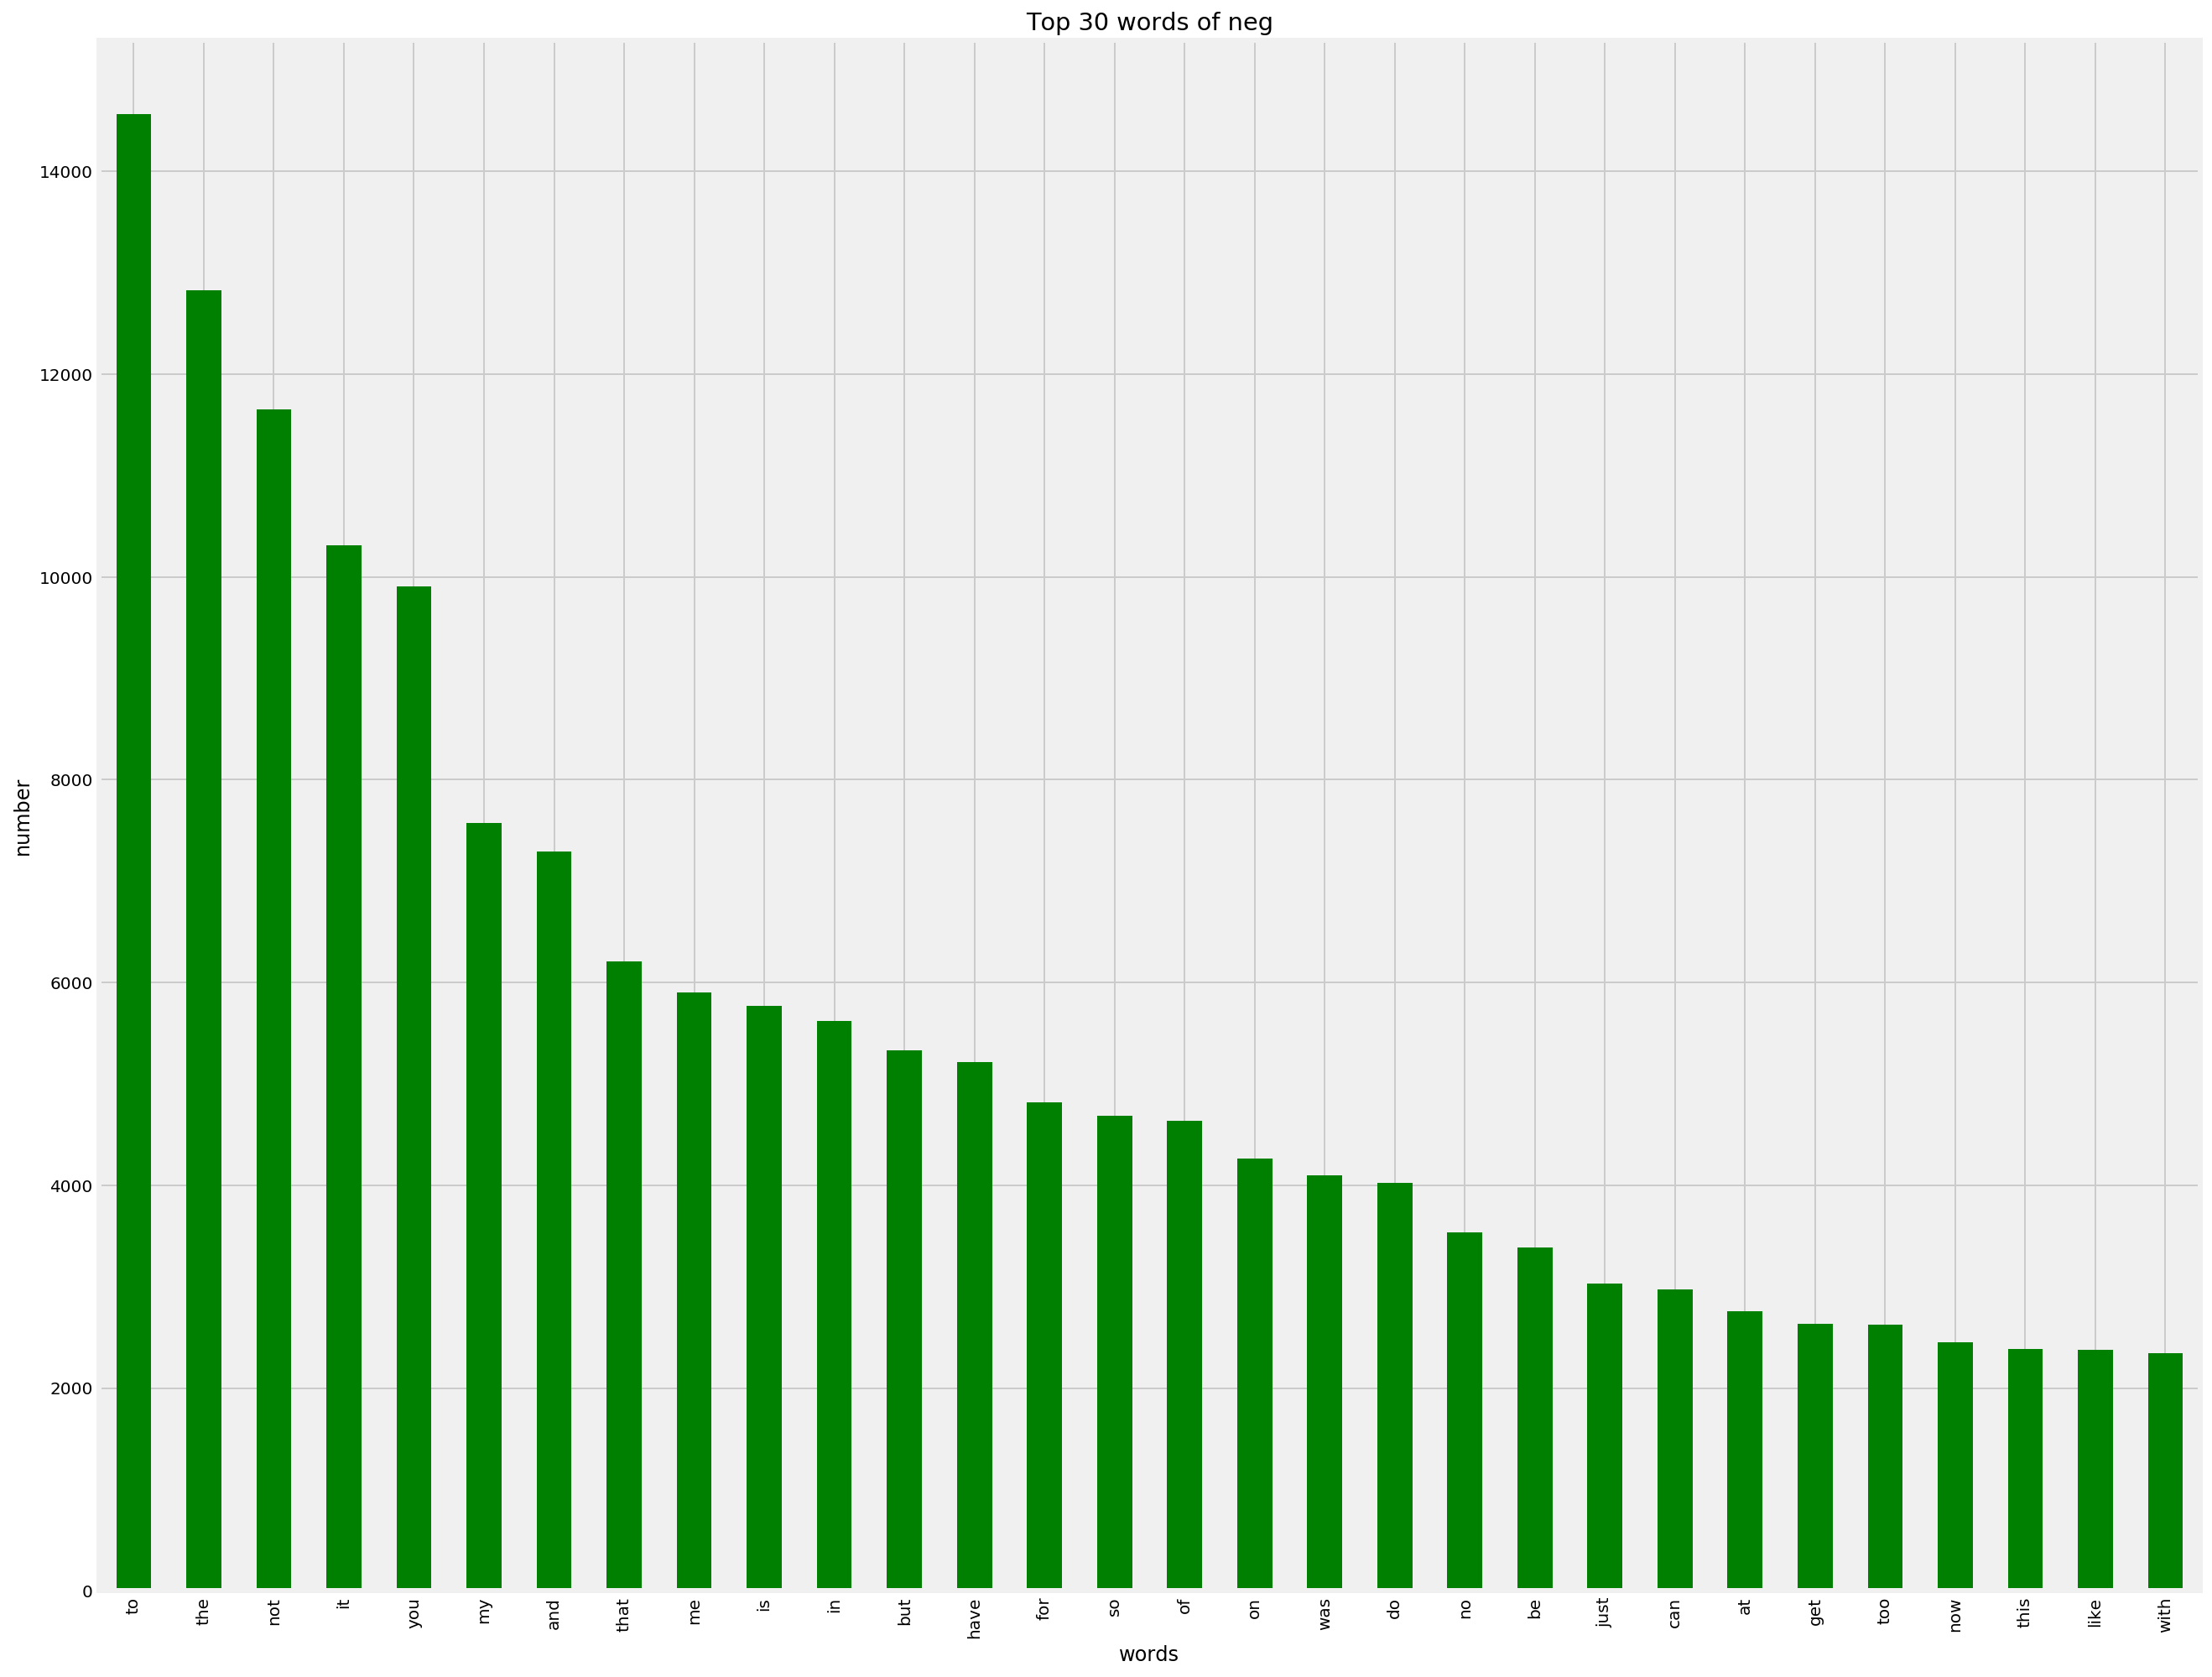

In [28]:
data2.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data2["words of neg"]))
plt.xticks(y_pos, data2["words of neg"])
plt.title('Top 30 words of neg')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

### Word Cloud
#### 1 word Cloud for negative strings

In [30]:
neg_tweets = clean_tweets_data[clean_tweets_data.sentiment == 0]
# neg_tweets

neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
# neg_string
neg_string = pd.Series(neg_string).str.cat(sep=' ')
# neg_string

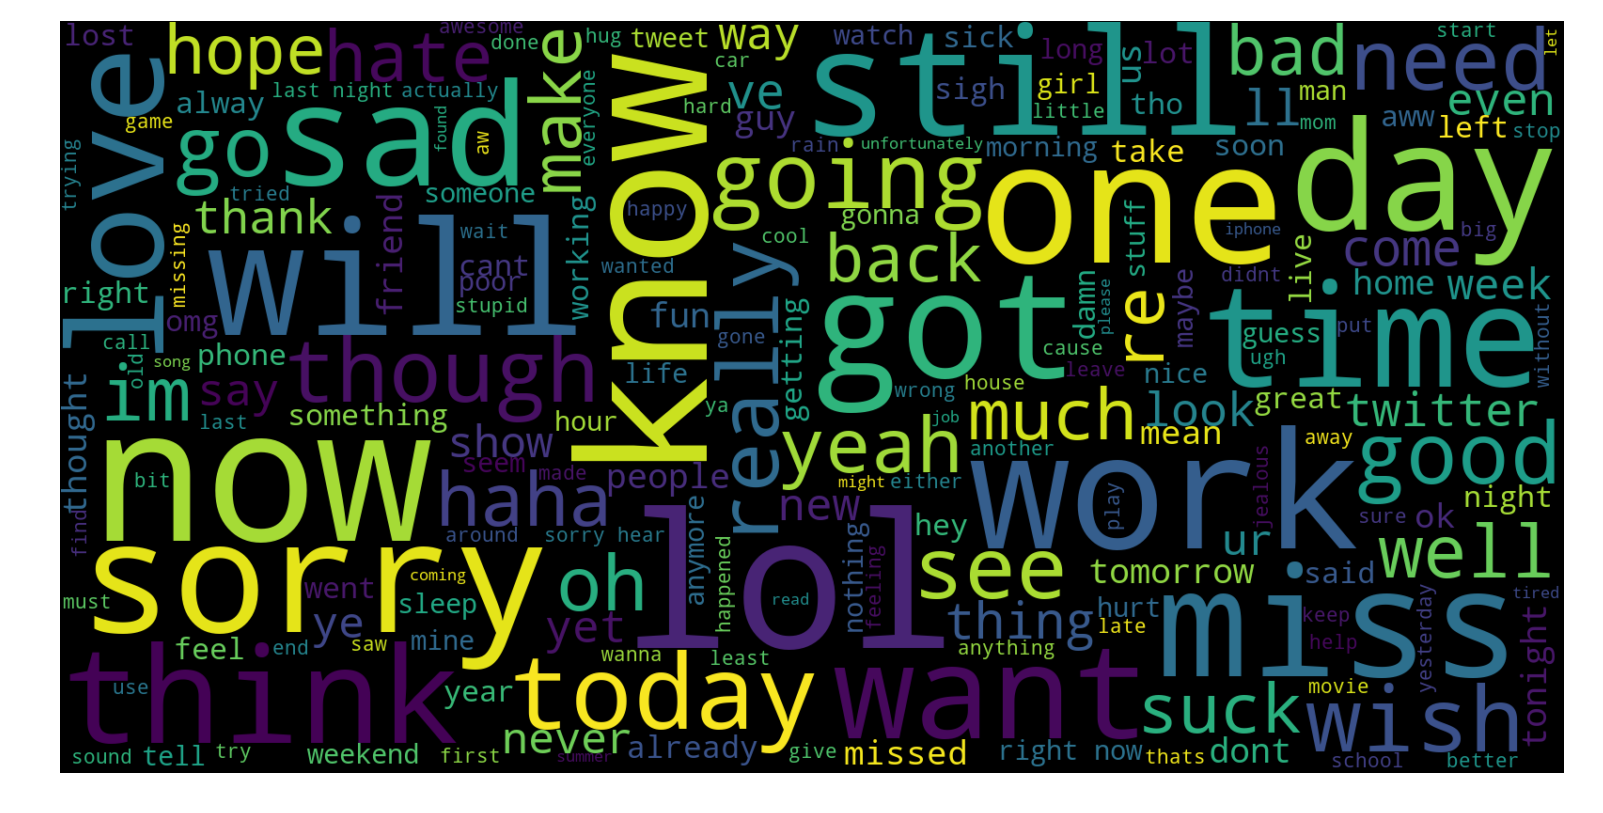

In [31]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

friends are leaving me cause of this stupid love
love you guys so much that it hurts
jus got hom fr tda funeral so sad cried so much times much love grandpa never got to say my last goodbye to him
miss my love jamie


OK, even though the tweets contain the word "love", in these cases it is negative sentiment because the tweet has mixed emotions like "love" but "miss". Or sometimes used in a sarcastic way.

#### 2 word Cloud for positive strings

In [33]:
pos_tweets = clean_tweets_data[clean_tweets_data.sentiment == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

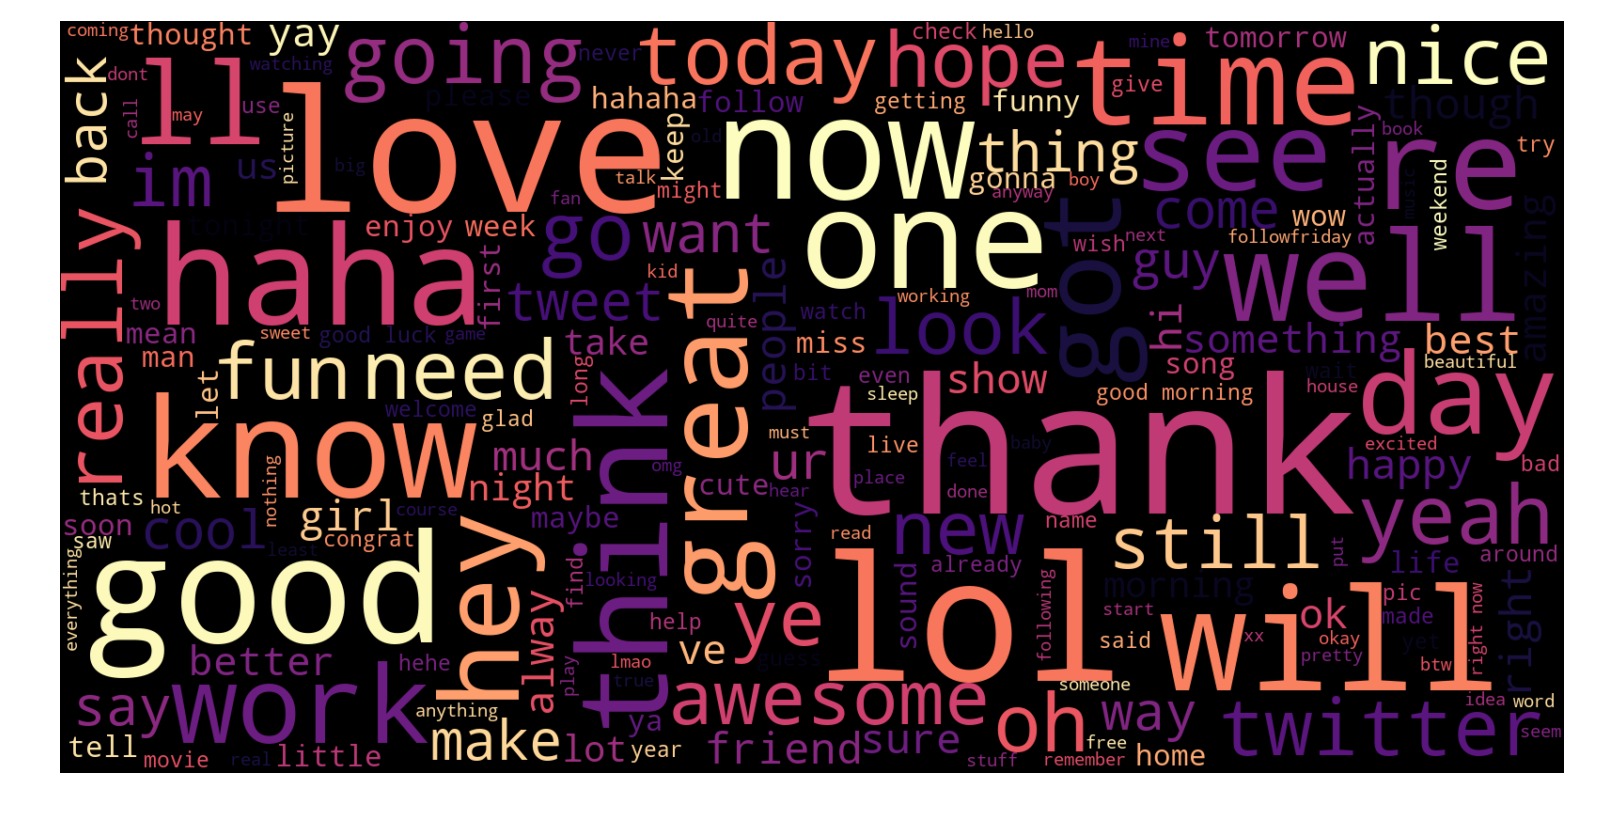

In [34]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### 3 word Cloud for all strings

In [35]:
all_string = []
for t in clean_tweets_data.text:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')

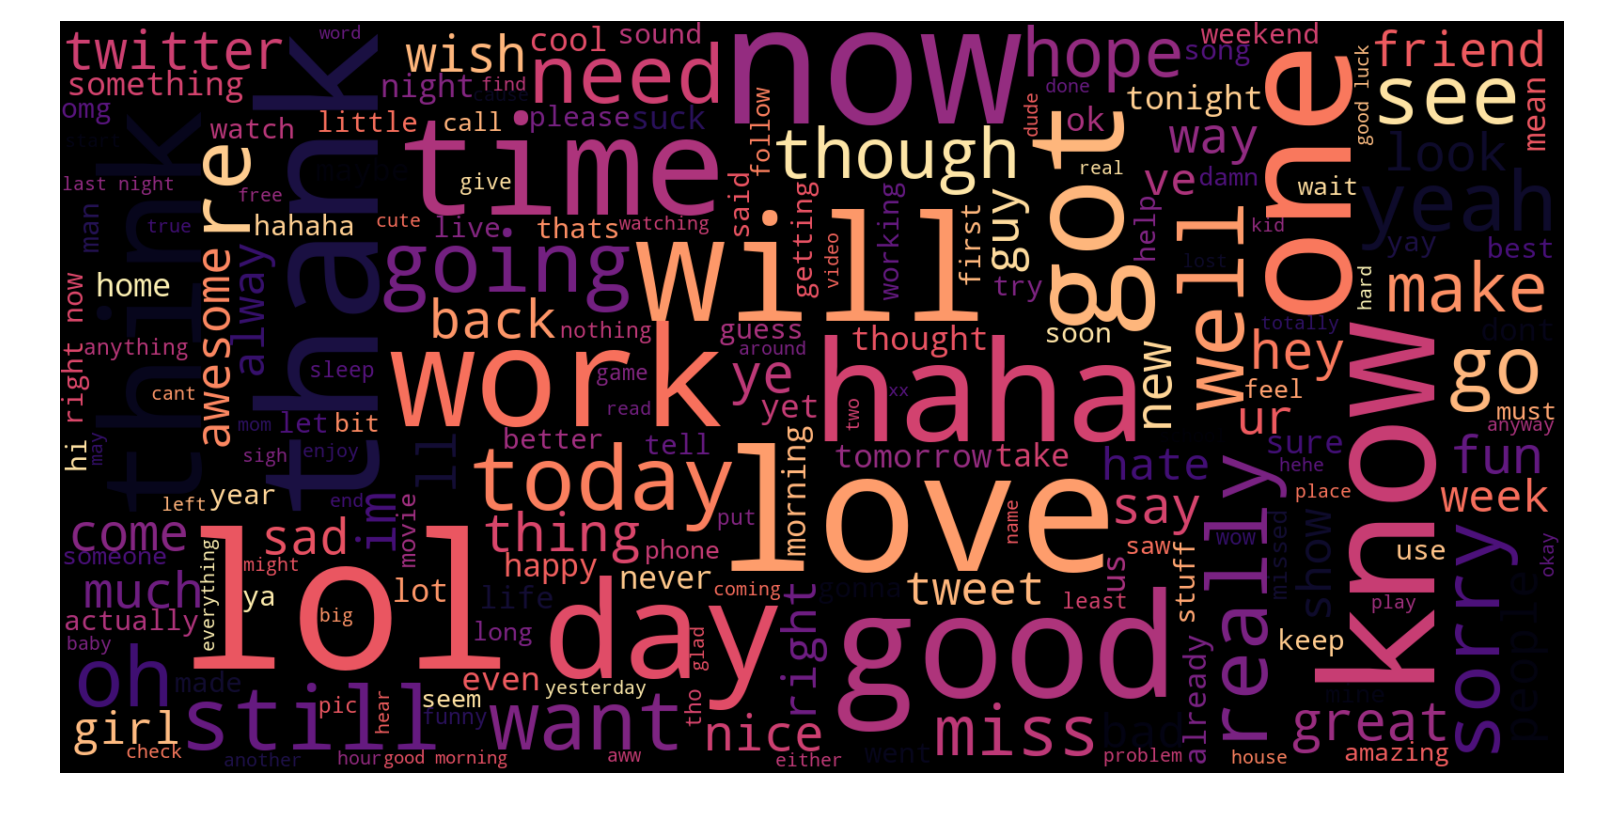

In [36]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, all_string #, df

# Models

## NaiveBayesClassifier with multiple Ngram (unigram and bigram)

In [38]:
stopwords_english = stopwords.words('english')

In [39]:
# clean words, i.e. remove stopwords and punctuation
def clean_words(words, stopwords_english):
    words_clean = []
#     print(type(words))
    for word in words:
        word = word.lower()
        if word not in stopwords_english and word not in string.punctuation:
            words_clean.append(word)    
    return words_clean 

In [40]:
# feature extractor function for unigram
def bag_of_words(words):    
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

In [41]:
# feature extractor function for ngrams (bigram)
def bag_of_ngrams(words, n=2):
    words_ng = []
    for item in iter(ngrams(words, n)):
        words_ng.append(item)
    words_dictionary = dict([word, True] for word in words_ng)    
    return words_dictionary

In [42]:
from nltk.tokenize import word_tokenize
text = "It was a very good movie."
words = word_tokenize(text.lower())
words

['it', 'was', 'a', 'very', 'good', 'movie', '.']

In [43]:
bag_of_ngrams(words)

{('it', 'was'): True,
 ('was', 'a'): True,
 ('a', 'very'): True,
 ('very', 'good'): True,
 ('good', 'movie'): True,
 ('movie', '.'): True}

In [44]:
words_clean = clean_words(words, stopwords_english)
words_clean

['good', 'movie']

In [45]:
important_words = ['above', 'below', 'off', 'over', 'under', 'more', 'most', 'such', 'no', 'nor', 'not', 'only', 'so', 'than', 'too', 'very', 'just', 'but']

In [46]:
stopwords_english_for_bigrams = set(stopwords_english) - set(important_words)

In [47]:
words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
words_clean_for_bigrams

['very', 'good', 'movie']

In [48]:
unigram_features = bag_of_words(words_clean)
unigram_features

{'good': True, 'movie': True}

In [49]:
bigram_features = bag_of_ngrams(words_clean_for_bigrams)
bigram_features

{('very', 'good'): True, ('good', 'movie'): True}

In [50]:
# combine both unigram and bigram features
all_features = unigram_features.copy()
all_features.update(bigram_features)
all_features

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [51]:
# let's define a new function that extracts all features
# i.e. that extracts both unigram and bigrams features
def bag_of_all_words(words, n=2):
    words_clean = clean_words(words, stopwords_english)
    words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
 
    unigram_features = bag_of_words(words_clean)
    bigram_features = bag_of_ngrams(words_clean_for_bigrams)
 
    all_features = unigram_features.copy()
    all_features.update(bigram_features)
 
    return all_features

In [52]:
bag_of_all_words(words)

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [56]:
# import numpy as np
# pos_reviews = np.array([row for row in tweet_data[tweet_data.sentiment == 1].text.str.split()])
pos_reviews = [row for row in clean_tweets_data[clean_tweets_data.sentiment == 1].text.str.split()]
# [value for (index, value) in pos_reviews.items()]
pos_reviews

[['omg', 'its', 'already'],
 ['handed', 'in', 'my', 'uniform', 'today', 'miss', 'you', 'already'],
 ['hmmmm', 'wonder', 'how', 'she', 'my', 'number'],
 ['thanks',
  'to',
  'all',
  'the',
  'haters',
  'up',
  'in',
  'my',
  'face',
  'all',
  'day'],
 ['feeling',
  'strangely',
  'fine',
  'now',
  'gonna',
  'go',
  'listen',
  'to',
  'some',
  'semisonic',
  'to',
  'celebrate'],
 ['you',
  're',
  'the',
  'only',
  'one',
  'who',
  'can',
  'see',
  'this',
  'cause',
  'no',
  'one',
  'else',
  'is',
  'following',
  'me',
  'this',
  'is',
  'for',
  'you',
  'because',
  'you',
  're',
  'pretty',
  'awesome'],
 ['goodbye', 'exams', 'hello', 'alcohol', 'tonight'],
 ['uploading', 'pictures', 'on', 'friendster'],
 ['so',
  'wrote',
  'something',
  'last',
  'week',
  'and',
  'got',
  'call',
  'from',
  'someone',
  'in',
  'the',
  'new',
  'york',
  'office'],
 ['do',
  'need',
  'to',
  'even',
  'say',
  'it',
  'do',
  'well',
  'here',
  'go',
  'anyways',
  'chris',

In [57]:
neg_reviews = [row for row in clean_tweets_data[clean_tweets_data.sentiment == 0].text.str.split()]
neg_reviews

[['is', 'so', 'sad', 'for', 'my', 'apl', 'friend'],
 ['missed', 'the', 'new', 'moon', 'trailer'],
 ['omgaga',
  'im',
  'sooo',
  'im',
  'gunna',
  'cry',
  've',
  'been',
  'at',
  'this',
  'dentist',
  'since',
  'was',
  'suposed',
  'just',
  'get',
  'crown',
  'put',
  'on',
  'mins'],
 ['think', 'mi', 'bf', 'is', 'cheating', 'on', 'me'],
 ['or', 'just', 'worry', 'too', 'much'],
 ['sunny', 'again', 'work', 'tomorrow', 'tv', 'tonight'],
 ['must', 'think', 'about', 'positive'],
 ['this', 'weekend', 'has', 'sucked', 'so', 'far'],
 ['jb', 'isnt', 'showing', 'in', 'australia', 'any', 'more'],
 ['ok', 'thats', 'it', 'you', 'win'],
 ['this', 'is', 'the', 'way', 'feel', 'right', 'now'],
 ['awhhe',
  'man',
  'completely',
  'useless',
  'rt',
  'now',
  'funny',
  'all',
  'can',
  'do',
  'is',
  'twitter'],
 ['huge', 'roll', 'of', 'thunder', 'just', 'now', 'so', 'scary'],
 ['just',
  'cut',
  'my',
  'beard',
  'off',
  'it',
  'only',
  'been',
  'growing',
  'for',
  'well',
  'ov

In [58]:
pos_reviews_set = []
for words in pos_reviews:
#     print(words)
    pos_reviews_set.append((bag_of_all_words(words), 'pos'))
pos_reviews_set

[({'omg': True, 'already': True, ('omg', 'already'): True}, 'pos'),
 ({'handed': True,
   'uniform': True,
   'today': True,
   'miss': True,
   'already': True,
   ('handed', 'uniform'): True,
   ('uniform', 'today'): True,
   ('today', 'miss'): True,
   ('miss', 'already'): True},
  'pos'),
 ({'hmmmm': True,
   'wonder': True,
   'number': True,
   ('hmmmm', 'wonder'): True,
   ('wonder', 'number'): True},
  'pos'),
 ({'thanks': True,
   'haters': True,
   'face': True,
   'day': True,
   ('thanks', 'haters'): True,
   ('haters', 'face'): True,
   ('face', 'day'): True},
  'pos'),
 ({'feeling': True,
   'strangely': True,
   'fine': True,
   'gonna': True,
   'go': True,
   'listen': True,
   'semisonic': True,
   'celebrate': True,
   ('feeling', 'strangely'): True,
   ('strangely', 'fine'): True,
   ('fine', 'gonna'): True,
   ('gonna', 'go'): True,
   ('go', 'listen'): True,
   ('listen', 'semisonic'): True,
   ('semisonic', 'celebrate'): True},
  'pos'),
 ({'one': True,
   'see':

In [59]:
neg_reviews_set = []
for words in neg_reviews:
#     print(words)
    neg_reviews_set.append((bag_of_all_words(words), 'neg'))
neg_reviews_set

[({'sad': True,
   'apl': True,
   'friend': True,
   ('so', 'sad'): True,
   ('sad', 'apl'): True,
   ('apl', 'friend'): True},
  'neg'),
 ({'missed': True,
   'new': True,
   'moon': True,
   'trailer': True,
   ('missed', 'new'): True,
   ('new', 'moon'): True,
   ('moon', 'trailer'): True},
  'neg'),
 ({'omgaga': True,
   'im': True,
   'sooo': True,
   'gunna': True,
   'cry': True,
   'dentist': True,
   'since': True,
   'suposed': True,
   'get': True,
   'crown': True,
   'put': True,
   'mins': True,
   ('omgaga', 'im'): True,
   ('im', 'sooo'): True,
   ('sooo', 'im'): True,
   ('im', 'gunna'): True,
   ('gunna', 'cry'): True,
   ('cry', 'dentist'): True,
   ('dentist', 'since'): True,
   ('since', 'suposed'): True,
   ('suposed', 'just'): True,
   ('just', 'get'): True,
   ('get', 'crown'): True,
   ('crown', 'put'): True,
   ('put', 'mins'): True},
  'neg'),
 ({'think': True,
   'mi': True,
   'bf': True,
   'cheating': True,
   ('think', 'mi'): True,
   ('mi', 'bf'): True

In [60]:
print (len(pos_reviews_set), len(neg_reviews_set)) # Output: (1000, 1000)
 
# radomize pos_reviews_set and neg_reviews_set
# doing so will output different accuracy result everytime we run the program
from random import shuffle 
shuffle(pos_reviews_set)
shuffle(neg_reviews_set)

test_set = pos_reviews_set[:int((0.2*len(pos_reviews_set)))] + neg_reviews_set[:int((0.2*len(neg_reviews_set)))]
train_set = pos_reviews_set[int((0.2*len(pos_reviews_set))):] + neg_reviews_set[int((0.2*len(neg_reviews_set))):]
 
print(len(test_set),  len(train_set))

56204 43319
19903 79620


In [61]:
%%time
from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy)
 
print (classifier.show_most_informative_features(10)) 

0.7350650655680048
Most Informative Features
    ('followers', 'day') = True              pos : neg    =     77.3 : 1.0
           ('so', 'sad') = True              neg : pos    =     55.2 : 1.0
         ('very', 'sad') = True              neg : pos    =     54.9 : 1.0
        ('makes', 'sad') = True              neg : pos    =     51.5 : 1.0
    ('get', 'followers') = True              pos : neg    =     48.2 : 1.0
        ('good', 'home') = True              neg : pos    =     37.6 : 1.0
    ('thanks', 'follow') = True              pos : neg    =     30.4 : 1.0
           ('im', 'sad') = True              neg : pos    =     26.4 : 1.0
                   cries = True              neg : pos    =     25.5 : 1.0
         ('sad', 'face') = True              neg : pos    =     22.9 : 1.0
None
CPU times: user 24.9 s, sys: 2.23 s, total: 27.2 s
Wall time: 27.8 s


In [62]:
from nltk.tokenize import word_tokenize

def test(text):
    custom_review_tokens = word_tokenize(text)
    custom_review_set = bag_of_all_words(custom_review_tokens)
    print (classifier.classify(custom_review_set))

    # probability result
    prob_result = classifier.prob_classify(custom_review_set)
    print (prob_result)
    print (prob_result.max())
    print (prob_result.prob("neg"))
    print (prob_result.prob("pos"))

In [63]:
custom_review = "I hated the film. It was a disaster. Poor direction, bad acting."
test(custom_review)

neg
<ProbDist with 2 samples>
neg
0.9957107900522985
0.004289209947704823


In [64]:
custom_review = "It was a wonderful and amazing movie. I loved it. Best direction, good acting."
test(custom_review)

pos
<ProbDist with 2 samples>
pos
0.02076945017321663
0.9792305498267877


In [65]:
custom_review = 'handed in my uniform today miss you already'
test(custom_review)

neg
<ProbDist with 2 samples>
neg
0.9998329259897347
0.0001670740102671897


In [66]:
custom_review = input('please enter a sentence :')
test(custom_review)

please enter a sentence :I like this girl
pos
<ProbDist with 2 samples>
pos
0.18722012403393742
0.8127798759660628


## splitting the tweets data into train and test sets

In [67]:
clean_tweets_data

,text,sentiment
0,is so sad for my apl friend,0
1,missed the new moon trailer,0
2,omg its already,1
3,omgaga im sooo im gunna cry ve been at this de...,0
4,think mi bf is cheating on me,0
...,...,...
99518,seems like repeating problem hope you re able ...,0
99519,arrrr we both replied to each other over diffe...,1
99520,ya thought so,0
99521,yes yes glad you had more fun with me,1


In [68]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweets_data['text'], clean_tweets_data['sentiment'], test_size = 0.3, random_state = 37)
print ("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  69666
X_test:  29857
y_train:  69666
y_test:  29857


In [69]:
# corpus = []
# for i in range(0,(len(clean_tweets_data))):
#     review = re.sub('[^a-zA-Z]', ' ', clean_tweets_data['text'][i])
#     review = review.lower()
#     review = review.split()
#     print(review)
#     ps = PorterStemmer()
#     review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
#     review = ' '.join(review)
#     corpus.append(review)

### Countvectorizer

In [81]:
cv = CountVectorizer(max_features = 1000)
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
X_train_cv = cv.transform(X_train)
X_train_cv

In [ ]:
X_test_cv = cv.transform(X_test)
X_test_cv

## MultiNominal Naive Bayes

In [ ]:
%%time
mnb = MultinomialNB(alpha = 0.5)
MNB_model = mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

In [80]:
print('Naive Bayes Accuracy: ', accuracy_score(y_mnb , y_test))
print('Naive Bayes confusion_matrix: ', confusion_matrix(y_mnb, y_test))
MNB_accuracy_train  = round(MNB_model.score(X_test_cv,y_test) * 100, 2)
MNB_accuracy_train 

Naive Bayes Accuracy:  0.7515155574907056
Naive Bayes confusion_matrix:  [[ 9071  3486]
 [ 3933 13367]]


75.15